# Vaccinations and assortativity (the "filmed" timeline*)

Goals for today:

* Fix an error with modeling in this script (the one that was fixed in our Zoom class)
* Make the parameter sweep block a bit more tidy
* Model herd immunity and vaccination rate
* Tangent: illustrate the meaning of it
    * Tangent on tangent: fix one or two errors that only become obvious at this point
* Measure assortativity
* Add assortativity to the network creator
    * To make it possible, we first need to refactor network initializer
* Test effects of assortativity

&nbsp;

**Footnote**: I call it the "filmed timeline" because [there exists a video](https://www.youtube.com/watch?v=ke_GvatMk5c) of me coding all that for about an hour and a half, in which for about 40 minutes I cannot understand why nothing works, debug every possible piece of it, only to realize at the *very end* that the algorithm I chose for creating assortative networks simply does not work. For a very weird, and very cool reason. It would have worked on a grid, and it might have worked in a Erdős graph (not sure), possibly, but it does NOT work on a Barabasi-Alberts network, or probably any other scale-free network. Which is truly bizarre :)

If you want an algorithm that works, you can consult an altenative timeline version of this file (named **"092_Vaccinations_multiverse"**, but there is no video of me coding it. Just go to where the `barabasi()` function is defined, and read it, it's pretty self-explanatory.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

A graph of 3 nodes:
0:[1]
1:[0]
2:[]

Nodes: [0, 1, 2]
Edges: [(0, 1)]
A graph of 2 nodes:
0:[]
2:[]



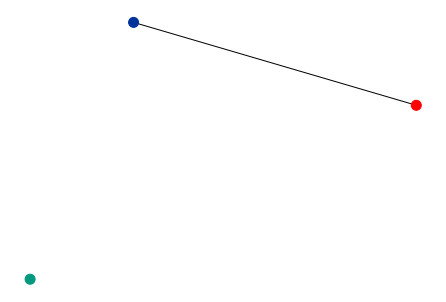

In [2]:
class Graph():
    def __init__(self):
        self.gdict = {}
        self.values = {}    # 0 for healthy, 1 for infected
        
    def add_node(self, node, val=None):
        """If node is not in a dictionary, add it."""
        if node not in self.gdict:
            self.gdict[node] = []
        self.values[node] = val
    
    def add_edge(self, node1, node2):        
        self.add_node(node1)
        self.add_node(node2)
        # Add node2 as a connection for node1, and the other way around
        if node2 not in self.gdict[node1]:
            self.gdict[node1].append(node2)
        if node1 not in self.gdict[node2]:
            self.gdict[node2].append(node1)
            
    def delete_node(self, doomed_node):
        if doomed_node not in self.gdict:
            raise KeyError(f"Cannot delete {doomed_node}; it doesn't exist!")
        for other_node in self.gdict[doomed_node]:
            self.gdict[other_node].remove(doomed_node)
        del self.gdict[doomed_node]
        del self.values[doomed_node]
            
    def delete_edge(self, node1, node2):
        if node1 not in self.gdict[node2]: return # This edge doesn't exist, done
        self.gdict[node1].remove(node2)
        self.gdict[node2].remove(node1)
            
    def get_nodes(self):
        """Returns a list of nodes."""
        return list(self.gdict.keys())
    
    def get_edges(self):
        """Returns a list of edges."""
        out = []
        for node,links in self.gdict.items():
            for link in links:
                if node<link:
                    out.append((node,link))
        return out
            
    def __str__(self):
        out = 'A graph of ' + str(len(self.gdict)) + ' nodes:\n'
        for node in self.gdict:
            out += str(node) + ':' + str(self.gdict[node]) + '\n'
        return out
    
    def plot(self):
        RED = (1, 0, 0)
        BLUE = (0, 0.2, 0.6)
        GREEN = (0, 0.6, 0.5)
        GRAY = (0.5, 0.5, 0.5)
        
        g_nx = nx.Graph()
        nodes = self.get_nodes()
        g_nx.add_nodes_from(nodes)
        g_nx.add_edges_from(self.get_edges())
        colors = []
        for i in range(len(nodes)):
            if self.values[nodes[i]] is not None:
                if self.values[nodes[i]][0]=='healthy':
                    colors.append(BLUE)
                elif self.values[nodes[i]][0]=='infected':
                    colors.append(RED)
                elif self.values[nodes[i]][0]=='vaccinated':
                    colors.append(GRAY)
                else:
                    colors.append(GREEN)
            else:
                colors.append(BLUE)
        nx.draw_kamada_kawai(g_nx, node_size=100, node_color=colors)
        #nx.draw_spring(g_nx, node_size=100, node_color=colors)
    
# Test
g = Graph()
g.add_edge(0,1)
g.add_edge(0,2)
g.delete_edge(0,2)
print(g)
print('Nodes:',g.get_nodes())
print('Edges:',g.get_edges())
g.values[0] = ['infected', None]
g.values[2] = ['immune', None]
g.plot()
g.delete_node(1)
print(g)

In [3]:
def degrees(g):
    """Calculates and plots the degrees distribution for a graph."""
    degrees = []
    for node,links in g.gdict.items():
        degrees.append(len(links))

    #print(degrees)
    hist = np.zeros(max(degrees)+1)
    for degree in degrees:
        hist[degree] += 1
    #print(hist)

    plt.plot(hist,'.-');
    plt.xlabel('Degrees')
    plt.ylabel('Frequency')
    
    return hist

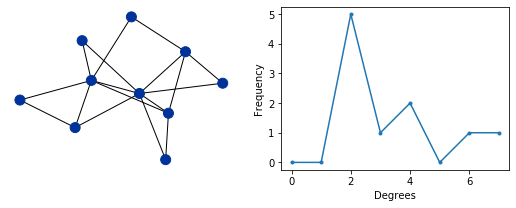

In [4]:
def barabasi(n_nodes=7):
    """Barabasi-Alberts network creator. N_edges ~ 2*N_nodes."""
    g = Graph()
    degrees = np.zeros(n_nodes)
    nodes = np.array(range(n_nodes))
    for i in range(n_nodes):
        if i==0:
            g.add_node(0)
        elif i==1:
            g.add_edge(1,0)
            degrees[0] = 1
            degrees[1] = 1
        else: # Actual preferential attachment
            connections = np.random.choice(nodes[:i], size=2, replace=False, p=degrees[:i]/np.sum(degrees))
            for node in connections:
                g.add_edge(i, node)
                degrees[node] += 1
            degrees[i] = 2
        #print(i,'Nodes:',nodes,'Degrees:',degrees)
    return g

g = barabasi(10)
plt.figure(figsize=(9,3))
plt.subplot(121)
g.plot()
plt.subplot(122)
degrees(g);

array([ 0.,  0., 27.,  6.,  5.,  4.,  3.,  0.,  0.,  2.,  0.,  0.,  0.,
        1.,  0.,  1.,  0.,  0.,  1.])

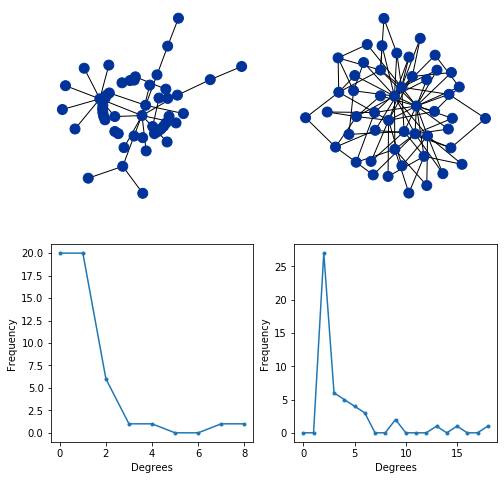

In [5]:
# Let's create a Barabasi network of 200 nodes
# Delete 150 nodes from it
# And compare it to a Barabasi network of 50 nodes

g = barabasi(200)
doomed_nodes = np.random.choice(range(200), 150, replace=False)
for node in doomed_nodes:
    g.delete_node(node)
    
plt.figure(figsize=(8,8))
plt.subplot(221)
g.plot()
plt.subplot(223)
degrees(g)

plt.subplot(222)
g = barabasi(50)
g.plot()
plt.subplot(224)
degrees(g)

# Assortativity

Three ways to actualy create assortative networks:

* Assign status early on, then connect (in the Barabasi model) depending not just on the degree, but also on status (either shared with the new node, or opposite of it). Upside: kinda nice to have all network creation together? Downsides: Need to move the code from pandemic; the network will no longer be Barabasi, strictly speaking.
* Create a network, then assign vaccination status based on whether the node has vaccinated friends. Upside: the degree distribution and other properties (modularity) will still match that of a Barabasi network. Downside: ?
* Create an "ideally assortative" (or anti-assortative) network, then randomize node status. Upside: real easy to do; we can achieve max and min assortativity. Downside: Harder to control? Harder to code?

In [ ]:
None[1]

In [110]:
def measure_assortativity(g):
    """Calcualte the probability that connected nodes share the value."""
    count = 0
    edges = g.get_edges()
    for edge in edges:
        if g.values[edge[0]][0]==g.values[edge[1]][0]:
            #print(g.values[edge[0]][0],g.values[edge[1]][0])
            count += 1
    return count/len(edges)

measure_assortativity(g)

0.7106598984771574

healthy healthy
healthy healthy
vaccinated vaccinated
vaccinated vaccinated
vaccinated vaccinated
vaccinated vaccinated
vaccinated vaccinated
healthy healthy
healthy healthy
healthy healthy
healthy healthy
healthy healthy
healthy healthy
healthy healthy
0.3783783783783784


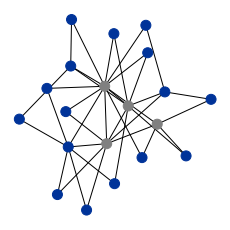

In [108]:
def vaccinate(g, vax_rate=0, preference=1):
    """Distribute vaccination status. Preferece==1 means no assorativity."""
    nodes = g.get_nodes()
    n_to_vaccinate = int(len(nodes)*vax_rate)
    prob = {}
    for node in nodes:
        prob[node] = 1
    for i in range(n_to_vaccinate):
        p = []
        for node in nodes:
            p.append(prob[node])
        target_node = np.random.choice(nodes, p=p/np.sum(p))
        g.values[target_node] = ['vaccinated', 0]
        for friend in g.gdict[target_node]:
            prob[friend] *= preference
        nodes.remove(target_node)
    for node in nodes: # The remaining nodes
        g.values[node] = ['healthy', 0]
    
    #for node in nodes:
    #    if np.random.uniform()<vax_rate:
    #        g.values[node] = ['vaccinated', 0]  # Vaccinated
    #    else:
    #        g.values[node] = ['healthy', 0]     # Succeptible
            
# Test
g = barabasi(20)
vaccinate(g, vax_rate=0.2, preference=100)
plt.figure(figsize=(3,3))
g.plot()
print(measure_assortativity(g))

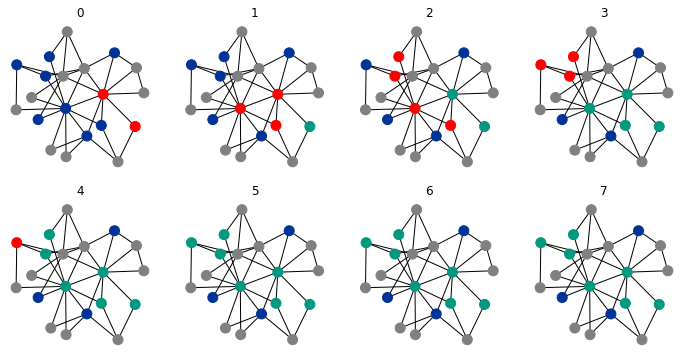

In [97]:
def pandemic(g, prob=0.5, nsteps=10, infect_period=1, reinitialize=True):
    """Runs the pandemic for several steps."""
    nodes = g.get_nodes()
    if reinitialize:
        #patient_zero = np.random.randint(low=0, high=len(nodes))
        succeptible = []
        for node in nodes:
            if g.values[node][0]=='healthy':
                succeptible.append(node)
        patient_zero = np.random.choice(succeptible)
        g.values[patient_zero] = ['infected', 0]  # Only one node is sick

    history = np.zeros(nsteps)
    for t in range(nsteps):
        newly_infected = []
        is_active = False
        for node in nodes:
            if g.values[node][0] == 'infected':         # If the node is infectious
                is_active = True
                if g.values[node][1] == infect_period:
                    g.values[node][0] = 'immune'
                else:
                    g.values[node][1] += 1                  # One more day since the infection
                    neighbors = g.gdict[node]
                    for neighbor in neighbors:
                        if g.values[neighbor][0]=='healthy' and np.random.uniform()<prob:
                            newly_infected.append(neighbor)
        if not is_active:
            return history
        for node in newly_infected:
            g.values[node] = ['infected', 0]
        history[t] = len(newly_infected)
    return history

# Test case
g = barabasi(20)
plt.figure(figsize=(12,6))
for i in range(8):
    if i==0:
        vaccinate(g, 0.5, 1)
        pandemic(g, prob=0.5, nsteps=1, infect_period=1)
    else:
        pandemic(g, prob=0.5, nsteps=1, infect_period=1, reinitialize=False)
    plt.subplot(2,4,i+1)
    g.plot()
    plt.title(i)

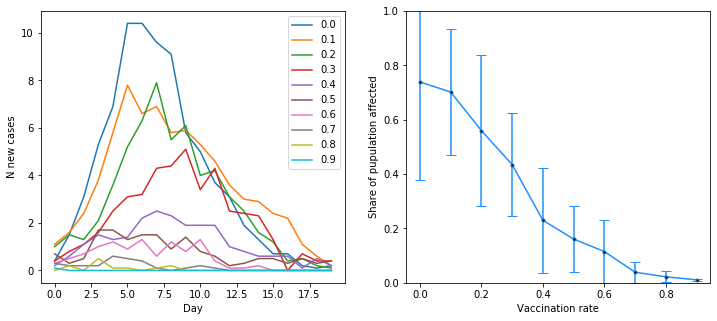

In [18]:
# Computational experiment: VACCINATION RATE

N_STEPS = 20
N_NODES = 100
PROB = 0.2      # Propagation probability: no longer a constant!
N_PARAM_STEPS = 10  # The model parameter will go though that many values
INFECT_PERIOD = 5
N_TRIALS = 10      # For each combination of parameters

history = np.zeros(shape=(N_STEPS, N_TRIALS*N_PARAM_STEPS))
total_infected = np.zeros(shape=(N_TRIALS, N_PARAM_STEPS))
vax_rate = np.zeros(N_PARAM_STEPS)
for iparam in range(N_PARAM_STEPS):
    vax_rate[iparam] = iparam/N_PARAM_STEPS
    for itrial in range(N_TRIALS):
        g = barabasi(N_NODES)
        vaccinate(g, vax_rate[iparam], 1)
        history[:, itrial+iparam*N_TRIALS] = pandemic(g, prob=PROB, 
                                                     nsteps=N_STEPS, infect_period=INFECT_PERIOD)
        count_infected = 0
        for node, val in g.values.items():
            if val[0]=='immune' or val[0]=='infected':
                count_infected += 1
        total_infected[itrial, iparam] = count_infected
        
plt.figure(figsize=(12,5))
plt.subplot(121)
for iparam in range(N_PARAM_STEPS):
    plt.plot(np.mean(history[:, (N_TRIALS*iparam):(N_TRIALS*(iparam+1))],axis=1), label=vax_rate[iparam]);
plt.xlabel('Day');
plt.ylabel('N new cases');
plt.legend(loc='upper right');

plt.subplot(122)
plt.plot(vax_rate, np.average(total_infected, axis=0)/N_NODES, '-', color='dodgerblue');
plt.errorbar(vax_rate, np.average(total_infected, axis=0)/N_NODES, 
             yerr=np.std(total_infected, axis=0)/N_NODES, fmt='.', capsize=5,
             ecolor='dodgerblue', markerfacecolor='k');
plt.xlabel('Vaccination rate');
plt.ylabel('Share of pupulation affected');
plt.ylim(0,1);

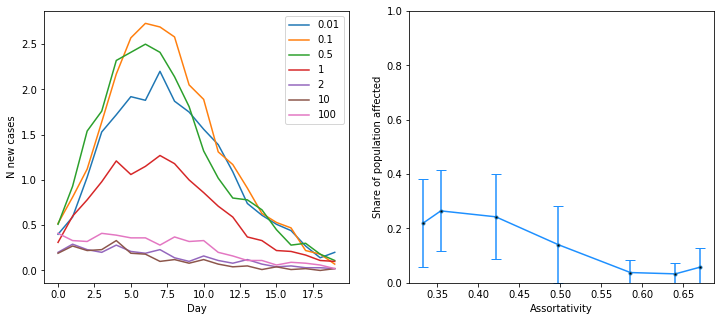

In [112]:
# Computational experiment: VACCINATION ASSORTATIVITY

N_STEPS = 20
N_NODES = 100
PROB = 0.2      # Propagation probability: no longer a constant!
VAX_RATE = 0.5
N_PARAM_STEPS = 7  # The model parameter will go though that many values
INFECT_PERIOD = 5
N_TRIALS = 100      # For each combination of parameters

preference = [0.01, 0.1, 0.5, 1, 2, 10, 100]

history = np.zeros(shape=(N_STEPS, N_TRIALS*N_PARAM_STEPS))
total_infected = np.zeros(shape=(N_TRIALS, N_PARAM_STEPS))
assort_history = np.zeros(shape=(N_TRIALS, N_PARAM_STEPS))
vax_rate = np.zeros(N_PARAM_STEPS)
for iparam in range(N_PARAM_STEPS):
    for itrial in range(N_TRIALS):
        g = barabasi(N_NODES)
        vaccinate(g, VAX_RATE, preference=preference[iparam])
        assort_history[itrial, iparam] = measure_assortativity(g)
        history[:, itrial+iparam*N_TRIALS] = pandemic(g, prob=PROB, 
                                                     nsteps=N_STEPS, infect_period=INFECT_PERIOD)
        count_infected = 0
        for node, val in g.values.items():
            if val[0]=='immune' or val[0]=='infected':
                count_infected += 1
        total_infected[itrial, iparam] = count_infected
        
plt.figure(figsize=(12,5))
plt.subplot(121)
for iparam in range(N_PARAM_STEPS):
    plt.plot(np.mean(history[:, (N_TRIALS*iparam):(N_TRIALS*(iparam+1))],axis=1), label=preference[iparam]);
plt.xlabel('Day');
plt.ylabel('N new cases');
plt.legend(loc='upper right');

plt.subplot(122)
plt.plot(np.average(assort_history, axis=0), np.average(total_infected, axis=0)/N_NODES, '-', color='dodgerblue');
plt.errorbar(np.average(assort_history, axis=0), np.average(total_infected, axis=0)/N_NODES, 
             yerr=np.std(total_infected, axis=0)/N_NODES, fmt='.', capsize=5,
             ecolor='dodgerblue', markerfacecolor='k');
plt.xlabel('Assortativity');
plt.ylabel('Share of population affected');
plt.ylim(0,1);